# Opdracht 3: Bepalen van muziekgenres

#### Simple
| Teamsleden | Kaggle gebruikernaam |
|---------|:--------|
|   Bram Veelenturf   | datasethacker   |
|   Maan Lammers  | Manu Lammers   |
|   Nika de Vries  | Nika de Vries   |
| Thida Churam| Thidarat Churam |


In [5]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt


## Opdracht 1



### features toevoegen

ChatGPT 5.2, promt 1: Audiofeature extractie functie, https://chatgpt.com/share/696699ab-8690-8009-adb3-e73b8e2ad8d6

In [6]:
import librosa
import numpy as np

def extract_features(file_path, sr=22050):
    """
    Extracts an extended set of audio features from a single audio file using librosa.

    The extracted features capture timbre, harmony, rhythm, dynamics and spectral
    characteristics, making them suitable for music genre recognition and
    unsupervised clustering.

    Parameters
    ----------
    file_path : str
        Path to the audio file.
    sr : int, optional
        Target sampling rate. Default is 22050 Hz.

    Returns
    -------
    list of float
        A list of numerical audio features.
    """

    # Load audio
    y, sr = librosa.load(file_path, sr=sr, mono=True)

    # =====================
    # TIMBRE (MFCC)
    # =====================
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc)
    mfcc_std = np.std(mfcc)

    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_mean = np.mean(mfcc_delta)

    # =====================
    # HARMONY
    # =====================
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma)
    chroma_std = np.std(chroma)

    tonnetz = librosa.feature.tonnetz(
        y=librosa.effects.harmonic(y), sr=sr
    )
    tonnetz_mean = np.mean(tonnetz)

    # =====================
    # SPECTRAL FEATURES
    # =====================
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))

    # =====================
    # TIME DOMAIN
    # =====================
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    dynamic_range = np.max(rms) - np.min(rms)

    # =====================
    # RHYTHM
    # =====================
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_strength_mean = np.mean(onset_env)

    tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    tempogram_mean = np.mean(tempogram)

    # =====================
    # HARMONIC / PERCUSSIVE
    # =====================
    y_harm, y_perc = librosa.effects.hpss(y)

    harmonic_energy = np.mean(librosa.feature.rms(y=y_harm))
    percussive_energy = np.mean(librosa.feature.rms(y=y_perc))

    hpss_ratio = harmonic_energy / (percussive_energy + 1e-6)

    # =====================
    # FEATURE VECTOR
    # =====================
    return [
        mfcc_mean,
        mfcc_std,
        mfcc_delta_mean,
        chroma_mean,
        chroma_std,
        tonnetz_mean,
        centroid,
        bandwidth,
        rolloff,
        contrast,
        flatness,
        zcr,
        rms_mean,
        dynamic_range,
        tempo,
        onset_strength_mean,
        tempogram_mean,
        harmonic_energy,
        percussive_energy,
        hpss_ratio
    ]


In [7]:
feature_names = [
    "mfcc_mean",
    "mfcc_std",
    "mfcc_delta_mean",
    "chroma_mean",
    "chroma_std",
    "tonnetz_mean",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_rolloff",
    "spectral_contrast",
    "spectral_flatness",
    "zcr",
    "rms_mean",
    "dynamic_range",
    "tempo",
    "onset_strength_mean",
    "tempogram_mean",
    "harmonic_energy",
    "percussive_energy",
    "hpss_ratio"
]

def add_features_to_dataframe(df, audio_folder, filename_column="filename"):
    """
    Computes audio features for all audio files listed in a DataFrame and
    appends them as new columns.

    This function iterates over the filenames in the given DataFrame, loads each
    corresponding audio file from the specified folder, extracts audio features
    using `extract_features`, and appends the resulting feature values as new columns.

    If a file cannot be processed (e.g., missing or corrupted), NaN values are inserted.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a column with audio file names.
    audio_folder : str
        Path to the folder containing the audio files.
    filename_column : str, optional
        Name of the column in `df` that contains the audio file names.
        Default is "filename".

    Returns
    -------
    pandas.DataFrame
        A new DataFrame containing the original columns plus 12 new feature columns:
        mfcc_mean, mfcc_std, chroma_mean, chroma_std, spectral_centroid,
        spectral_bandwidth, spectral_rolloff, zcr, rms, tempo, spectral_contrast, tonnetz.
    """

    features = []

    for file in tqdm(df[filename_column]):
        path = os.path.join(audio_folder, file)
        try:
            feat = extract_features(path)
        except:
            feat = [np.nan] * 12   # als bestand corrupt is
        features.append(feat)

    features_df = pd.DataFrame(features, columns=feature_names)
    return pd.concat([df.reset_index(drop=True), features_df], axis=1)


In [8]:
df1 = pd.read_csv("labels_new.csv")
df1 = add_features_to_dataframe(df1, "labeled")

100%|██████████| 50/50 [05:30<00:00,  6.61s/it]


In [9]:

df1

filename      genre  mfcc_mean    mfcc_std  mfcc_delta_mean  \
0   m00248.wav      metal   5.699205   41.039814         0.001120   
1   m00230.wav    country   1.406993   33.670486         0.007515   
2   m00637.wav     hiphop   1.534439   49.569447        -0.010377   
3   m00627.wav      metal   3.919076   41.615543        -0.000399   
4   m00138.wav     reggae  -2.216035   68.107262        -0.006674   
5   m00192.wav  classical  -0.664244   43.296108         0.001438   
6   m00429.wav     hiphop   4.164687   46.288422         0.002953   
7   m00623.wav     reggae  -1.444500   42.986076        -0.001623   
8   m00002.wav       jazz -10.899069   89.951332         0.004429   
9   m00039.wav     reggae  -0.444924   64.211784         0.000954   
10  m00677.wav    country   0.246956   58.305908         0.013058   
11  m00867.wav       rock  -1.506830   58.245068         0.007362   
12  m00503.wav      metal   1.060839   45.923958        -0.002269   
13  m00421.wav        pop   5.107764   38.259075        -0.007153   
14  m00501.wav       jazz  -3.524840   59.213802        -0.003601   
15  m00801.wav       rock  -5.199506   67.090729         0.011562   
16  m00400.wav      blues  -4.548970  110.346474        -0.001321   
17  m00629.wav    country   4.037237   46.912075         0.000259   
18  m00762.wav      disco   3.712976   56.205570         0.009953   
19  m00895.wav       rock   8.529411   29.701508         0.003946   
20  m00678.wav      metal   4.161820   49.071846         0.002588   
21  m00671.wav     reggae  -4.121209   81.904930        -0.012778   
22  m00206.wav     hiphop   3.788612   43.137489         0.003180   
23  m00676.wav        pop   5.221028   30.658615        -0.010073   
24  m00821.wav      metal   3.493953   38.412113        -0.003162   
25  m00112.wav     reggae  -2.947418   83.502739         0.017982   
26  m00773.wav        pop  -5.604658   67.672729         0.012632   
27  m00313.wav      blues  -2.169419   83.806938         0.001128   
28  m00633.wav    country   2.395818   54.444405        -0.003137   
29  m00072.wav      disco  -0.289335   35.235195        -0.005184   
30  m00996.wav       jazz  -2.759144   82.609718        -0.006236   
31  m00716.wav       jazz  -4.936887   68.544853         0.003924   
32  m00351.wav       jazz  -4.313087   65.441757         0.002881   
33  m00606.wav    country  -1.641476   64.652603        -0.002714   
34  m00096.wav      disco   1.670264   46.088760        -0.011304   
35  m00454.wav     hiphop   4.292896   43.736908        -0.001304   
36  m00553.wav      disco   4.402936   51.620014         0.001174   
37  m00772.wav       rock  -1.598386   55.032688         0.001443   
38  m00658.wav     hiphop   3.379371   45.739708         0.019441   
39  m00338.wav      blues   7.687974   44.207092         0.005094   
40  m00298.wav      blues  -6.929910   73.496483        -0.007194   
41  m00850.wav      disco   3.974319   37.343704         0.001849   
42  m00513.wav        pop   5.735095   28.015697         0.003376   
43  m00041.wav        pop   3.580127   28.499043        -0.011953   
44  m00339.wav       rock  -1.040524   41.790329         0.001146   
45  m00253.wav      blues   9.977621   34.135380         0.003465   
46  m00435.wav  classical  -9.927390   69.033440        -0.008489   
47  m00236.wav  classical -22.748804  108.704788        -0.000713   
48  m00102.wav  classical -24.515097  127.903122        -0.000092   
49  m00477.wav  classical -18.538795  121.748024         0.000337   

    chroma_mean  chroma_std  tonnetz_mean  spectral_centroid  \
0      0.581162    0.242194     -0.007153        2656.941556   
1      0.437729    0.274154     -0.007863        3760.408113   
2      0.503631    0.288337     -0.010936        2290.939647   
3      0.513275    0.258947     -0.008960        2378.492400   
4      0.418510    0.312810      0.021368        1995.276965   
5      0.346840    0.280396     -0.013215        1878.494004   
6      0.482570    0.293664      0.009

#### Features uitleg

1. MFCC Mean (mfcc_mean)
$$
MFCC_{mean} = \frac{1}{T} \sum_{t=1}^{T} MFCC(t)
$$

MFCC staat voor Mel-Frequency Cepstral Coefficients. Deze waarden beschrijven van het karakter of de kwaliteit van een muzikaal geluid, onafhankelijk van volume of toonhoogte. De mean is het gemiddelde van deze waarden over de hele opname. Dus het is een samenvatting van de klankkleur van het fragment, bijvoorbeeld warm, scherp of dof.

Het audiosignaal wordt omgezet van het tijdsdomein naar het frequentiedomein met behulp van een Fouriertransformatie. Vervolgens wordt het signaal omgezet naar de Mel-schaal, die overeenkomt met de manier waarop het menselijk oor geluid waarneemt. Daarna wordt de logaritme van deze waarden genomen. Ten slotte wordt een Discrete Cosine Transform (DCT) toegepast. Dit is een wiskundige techniek die een signaal uit het tijds- of frequentiedomein omzet naar een set cosinusgolven.


2. MFCC Standard Deviation (mfcc_std)

$$
MFCC_{std} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} (MFCC(t) - MFCC_{mean})^2}
$$

Het is de spreiding van de MFCC-waarden. Deze feature geeft aan hoe sterk de klankkleur in een nummer verandert in de tijd. Na het berekenen van de MFCC’s per tijdframe wordt de standaardafwijking van deze waarden genomen. Een lage standaardafwijking betekent dat het geluid vrij constant is, terwijl een hoge waarde betekent dat het timbre sterk varieert.

3. MFCC delta mean (mfcc_delta_mean)

In deze feature zitten er 3 delen in. MFCC beschrijft het spectrale timbre. Delta beschrijft verandering in de tijd. Mean is het gemiddelde over het hele fragment. Alle drie samen berekend als de tijdsafgeleide van MFCC’s en vervolgens gemiddeld over tijd en coëfficiënten.

4. Chroma mean (chroma_mean)

$$
Chroma_{mean} = \frac{1}{12T} \sum_{i=1}^{12} \sum_{t=1}^{T} chroma_i(t)
$$

HET beschrijft hoe de energie is verdeeld over de 12 muzieknoten (C, C#, D, …, B). Het kijkt niet naar hoe hoog een noot is, maar alleen welke noot het is. Het spectrum laat zien op 12 toonklassen. Voor elk tijdframe wordt de energie per toon berekend en vervolgens wordt het gemiddelde genomen.

5. Chroma Standard Deviation (chroma_std)
$$
Chroma_{std} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} (chroma(t) - Chroma_{mean})^2}
$$

Het geeft aan hoeveel de toonhoogte-verdeling afwisselt in een nummer. Muziek met veel akkoordwisselingen heeft een hogere waarde dan monotone muziek. De standaardafwijking wordt gemeten van de chroma-waarden over alle tijdframes.

6. Spectral Centroid (spectral_centroid)

De spectrale centroid meet de vorm van het spectrum van EEG-signalen. EEG-signalen zijn de elektrische activiteit van de hersenen, gemeten met elektroden op de hoofdhuid, die worden weergegeven als lijngrafieken. Een hogere SC-waarde komt overeen met een hogere concentratie van signaalenergie in de hogere frequenties. Spectral centroid geeft dus aan of een muziekfragment vooral uit lage of hoge tonen bestaat. Het wordt berekend als het gewogen gemiddelde van alle frequenties, waarbij de gewichten worden bepaald door de energie op die frequenties.

Hoge waarden → veel hoge tonen

Lage waarden → warm geluid

7. Spectral Bandwidth (spectral_bandwidth)
$$
Bandwidth = \sqrt{\frac{\sum_k (f_k - Centroid)^2 \cdot S(f_k)}{\sum_k S(f_k)}}
$$


Het geeft aan hoe breed het frequentiespectrum is rond het spectral centroid. Een grote bandwidth wijst op een complex en rijk geluid. Deze wordt berekend als de standaardafwijking van de frequenties rond het spectral centroid, gewogen naar hun energie.

8. Spectral Rolloff (spectral_rolloff)

Spectral Rolloff is een audio-eigenschap die de frequentie aangeeft waaronder een bepaald percentage 85% van de totale spectrale energie van een geluidssignaal geconcentreerd is, wat helpt bij het beschrijven of een geluid toonachtig of ruisachtig. Dit zegt iets over hoeveel hoge tonen aanwezig zijn. De frequentie wordt dus gezocht waarbij 85% van de totale spectrale energie is bereikt.

9. Spectral_contrast

$$
Contrast = Peak_{band} - Valley_{band}
$$

Spectral Contrast is het verschil tussen sterke en zwakke frequenties in het spectrum. Bijvoorbeeld Hoe scherp of vlak het geluid is. Voor verschillende frequentiebanden wordt het verschil genomen tussen pieken en dalen.

10. Spectral_flatness

DEze feature verteld hoe gelijkmatig de energie van een audiosignaal verdeeld is over het frequentiespectrum. Wanneer een signaal wordt gedomineerd door duidelijke harmonische frequenties, is de spectral flatness laag. Bij ruisachtige of percussieve signalen, waarbij de energie gelijkmatig over de frequenties is verspreid, is de spectral flatness hoog. Hierdoor is spectral flatness vooral geschikt om onderscheid te maken tussen harmonische en ruisachtige geluiden.

11. Zero Crossing Rate (zcr)
$$
ZCR = \frac{1}{N} \sum_{n=1}^{N} |sign(x_n) - sign(x_{n-1})|
$$

Zero Crossing Rate geeft aan hoe vaak het audiosignaal van positief naar negatief wisselt. Dit zegt iets over ruis en scherpte. Het aantal tekenwisselingen in het signaal wordt gedeeld door het totaal aantal samples.

12. RMS mean
$$
RMS = \sqrt{\frac{1}{N} \sum_{n=1}^{N} x_n^2}
$$

RMS geeft de gemiddelde energie (luidheid) van het fragment. Hardere muziek zoals metal en disco heeft meestal hogere RMS-waarden. De wortel van het gemiddelde van de kwadraten van de signaalwaarden.

13. Dynamic_range

Deze feature beschrijft het verschil tussen de zachtste en de luidste delen van een audiosignaal. Het geeft aan hoeveel variatie er is in geluidssterkte over de tijd. Een grote dynamische range betekent dat het signaal zowel zeer zachte als zeer luide passages bevat, wat vaak voorkomt in bijvoorbeeld klassieke muziek. Een kleine dynamische range duidt op sterk gecomprimeerd of constant luid geluid, zoals bij veel pop muziek Het featuere wordt meestal berekend als het verschil tussen de maximale en minimale (of gemiddelde) energie, vaak uitgedrukt in decibel.

14. Tempo

Het tempo geeft het aantal beats per minuut (BPM) en zegt iets over hoe snel de muziek is. Het kan bepaald worden door Librosa die gebruikt een beat-detectie algoritme dat pieken in het energiesignaal analyseert om het tempo te schatten.


15. Onset_strength_mean
$$
\text{onset\_strength\_mean}
=
\frac{1}{T}
\sum_{t=1}^{T}
O(t)
$$

- $O(t)$ de onset strength is op tijdframe $t$
- $T$ het totaal aantal tijdframes

Deze feaure geeft de gemiddelde sterkte van muzikale onsets in een audiosignaal. Een onset is het moment waarop een nieuw geluid of noot begint, meestal gekenmerkt door een plotselinge toename in energie in het spectrum. De onset strength wordt per tijdframe berekend op basis van veranderingen in spectrale energie, en onset_strength_mean is het gemiddelde van deze waarden over het hele fragment.

16. Tempogram_mean

Deze feature vertelt hoe sterk het ritme in een muziekfragment gemiddeld aanwezig is. Om deze feature te berekenen wordt eerst een tempogram gemaakt, waarin voor elk moment in de muziek wordt gemeten hoe duidelijk verschillende tempi hoorbaar zijn. Tempi betekent verschillende mogelijke snelheden van het ritme in muziek. Dus tempi gebruik je wanneer je het hebt over meer dan één tempo tegelijk. En door alle waarden in het tempogram te middelen ontstaat de tempogram_mean.

17. Harmonic energy

Deze feature beschrijft hoeveel van de totale energie van een audiosignaal afkomstig is van harmonische, toonachtige componenten. Het signaal wordt hierbij eerst opgesplitst in een harmonisch en een percussief deel. Harmonisch geluid heeft een duidelijke toonhoogte en klinkt door, terwijl percussief geluid kort en ritmisch is zonder vaste toon. De harmonic energy wordt vervolgens berekend als de energie van het harmonische component en geeft aan in hoeverre het geluid wordt gedomineerd door duidelijke toonhoogtes en harmonischen.

18. Percussive_energy

Percussive energy beschrijft hoeveel van de totale energie van een audiosignaal afkomstig is van percussieve componenten. Zoals harmonic energy wordt het audiosignaal wordt hiervoor opgesplitst in een harmonisch en een percussief deel, waarbij het percussieve deel bestaat uit korte, scherpe geluiden zoals drums en andere ritmische aanslagen.

19. Hpss_ratio

Deze feature zegt over beschrijft de verhouding tussen de harmonische en percussieve energie in een audiosignaal. De HPSS ratio wordt vervolgens berekend als de verhouding tussen deze twee energiewaarden en geeft aan of een muziekfragment meer wordt gedomineerd door melodische/ harmonische of ritmische/percussieve elementen.

20. Tonnetz mean
$$
Tonnetzmean= \frac{1}{6T} \sum_{i=1}^{6} \sum_{t=1}^{T} z_i(t)
$$

Tonnetz kijkt naar welke tonen samen mooi klinken en probeert dit soort muzikale relaties te meten en beschrijven. Dit gebeurt door chroma-features worden omgezet naar een toonruimte (12 getallen) die muzikale relaties tussen tonen vastlegt. Daarna combineert librosa deze 12 chroma-waarden met vaste wiskundige formules. Dan kan je zien hoe sterk de muziek harmonieus georganiseerd is. De mean berekent dan het gemiddelde toonhoogte- en akkoordstructuur van een muziekfragment.

### EDA

In [10]:
print(df1.shape)
print(df1.info())
print(df1.isna().sum())


(50, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             50 non-null     object 
 1   genre                50 non-null     object 
 2   mfcc_mean            50 non-null     float32
 3   mfcc_std             50 non-null     float32
 4   mfcc_delta_mean      50 non-null     float32
 5   chroma_mean          50 non-null     float32
 6   chroma_std           50 non-null     float32
 7   tonnetz_mean         50 non-null     float64
 8   spectral_centroid    50 non-null     float64
 9   spectral_bandwidth   50 non-null     float64
 10  spectral_rolloff     50 non-null     float64
 11  spectral_contrast    50 non-null     float64
 12  spectral_flatness    50 non-null     float32
 13  zcr                  50 non-null     float64
 14  rms_mean             50 non-null     float32
 15  dynamic_range        50 non-null 

In [11]:
# tempo omzetten naar nummerieke kolom
df1["tempo"] = df1["tempo"].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
df1["tempo"] = pd.to_numeric(df1["tempo"], errors="coerce")
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             50 non-null     object 
 1   genre                50 non-null     object 
 2   mfcc_mean            50 non-null     float32
 3   mfcc_std             50 non-null     float32
 4   mfcc_delta_mean      50 non-null     float32
 5   chroma_mean          50 non-null     float32
 6   chroma_std           50 non-null     float32
 7   tonnetz_mean         50 non-null     float64
 8   spectral_centroid    50 non-null     float64
 9   spectral_bandwidth   50 non-null     float64
 10  spectral_rolloff     50 non-null     float64
 11  spectral_contrast    50 non-null     float64
 12  spectral_flatness    50 non-null     float32
 13  zcr                  50 non-null     float64
 14  rms_mean             50 non-null     float32
 15  dynamic_range        50 non-null     float

In [12]:
df1

filename      genre  mfcc_mean    mfcc_std  mfcc_delta_mean  \
0   m00248.wav      metal   5.699205   41.039814         0.001120   
1   m00230.wav    country   1.406993   33.670486         0.007515   
2   m00637.wav     hiphop   1.534439   49.569447        -0.010377   
3   m00627.wav      metal   3.919076   41.615543        -0.000399   
4   m00138.wav     reggae  -2.216035   68.107262        -0.006674   
5   m00192.wav  classical  -0.664244   43.296108         0.001438   
6   m00429.wav     hiphop   4.164687   46.288422         0.002953   
7   m00623.wav     reggae  -1.444500   42.986076        -0.001623   
8   m00002.wav       jazz -10.899069   89.951332         0.004429   
9   m00039.wav     reggae  -0.444924   64.211784         0.000954   
10  m00677.wav    country   0.246956   58.305908         0.013058   
11  m00867.wav       rock  -1.506830   58.245068         0.007362   
12  m00503.wav      metal   1.060839   45.923958        -0.002269   
13  m00421.wav        pop   5.107764   38.259075        -0.007153   
14  m00501.wav       jazz  -3.524840   59.213802        -0.003601   
15  m00801.wav       rock  -5.199506   67.090729         0.011562   
16  m00400.wav      blues  -4.548970  110.346474        -0.001321   
17  m00629.wav    country   4.037237   46.912075         0.000259   
18  m00762.wav      disco   3.712976   56.205570         0.009953   
19  m00895.wav       rock   8.529411   29.701508         0.003946   
20  m00678.wav      metal   4.161820   49.071846         0.002588   
21  m00671.wav     reggae  -4.121209   81.904930        -0.012778   
22  m00206.wav     hiphop   3.788612   43.137489         0.003180   
23  m00676.wav        pop   5.221028   30.658615        -0.010073   
24  m00821.wav      metal   3.493953   38.412113        -0.003162   
25  m00112.wav     reggae  -2.947418   83.502739         0.017982   
26  m00773.wav        pop  -5.604658   67.672729         0.012632   
27  m00313.wav      blues  -2.169419   83.806938         0.001128   
28  m00633.wav    country   2.395818   54.444405        -0.003137   
29  m00072.wav      disco  -0.289335   35.235195        -0.005184   
30  m00996.wav       jazz  -2.759144   82.609718        -0.006236   
31  m00716.wav       jazz  -4.936887   68.544853         0.003924   
32  m00351.wav       jazz  -4.313087   65.441757         0.002881   
33  m00606.wav    country  -1.641476   64.652603        -0.002714   
34  m00096.wav      disco   1.670264   46.088760        -0.011304   
35  m00454.wav     hiphop   4.292896   43.736908        -0.001304   
36  m00553.wav      disco   4.402936   51.620014         0.001174   
37  m00772.wav       rock  -1.598386   55.032688         0.001443   
38  m00658.wav     hiphop   3.379371   45.739708         0.019441   
39  m00338.wav      blues   7.687974   44.207092         0.005094   
40  m00298.wav      blues  -6.929910   73.496483        -0.007194   
41  m00850.wav      disco   3.974319   37.343704         0.001849   
42  m00513.wav        pop   5.735095   28.015697         0.003376   
43  m00041.wav        pop   3.580127   28.499043        -0.011953   
44  m00339.wav       rock  -1.040524   41.790329         0.001146   
45  m00253.wav      blues   9.977621   34.135380         0.003465   
46  m00435.wav  classical  -9.927390   69.033440        -0.008489   
47  m00236.wav  classical -22.748804  108.704788        -0.000713   
48  m00102.wav  classical -24.515097  127.903122        -0.000092   
49  m00477.wav  classical -18.538795  121.748024         0.000337   

    chroma_mean  chroma_std  tonnetz_mean  spectral_centroid  \
0      0.581162    0.242194     -0.007153        2656.941556   
1      0.437729    0.274154     -0.007863        3760.408113   
2      0.503631    0.288337     -0.010936        2290.939647   
3      0.513275    0.258947     -0.008960        2378.492400   
4      0.418510    0.312810      0.021368        1995.276965   
5      0.346840    0.280396     -0.013215        1878.494004   
6      0.482570    0.293664      0.009

___

### Opdracht 2

In [13]:
def list_wav_files(folder_path):
    wav_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(".wav")
    ]
    return pd.DataFrame({"filename": wav_files})

df_unlabeled = list_wav_files("unlabeled")
print(df_unlabeled)

df_unlabeled = add_features_to_dataframe(df_unlabeled, "unlabeled")

       filename
0    m00156.wav
1    m00289.wav
2    m00293.wav
3    m00309.wav
4    m00107.wav
..          ...
100  m00736.wav
101  m00571.wav
102  m00321.wav
103  m00495.wav
104  m00247.wav

[105 rows x 1 columns]


100%|██████████| 105/105 [10:18<00:00,  5.89s/it]


filename  mfcc_mean    mfcc_std  mfcc_delta_mean  chroma_mean  \
0    m00156.wav -30.154657  158.767685         0.003996     0.225095   
1    m00289.wav   2.960290   40.840927        -0.001213     0.509197   
2    m00293.wav  11.742577   36.091175        -0.002562     0.478729   
3    m00309.wav -11.054369   92.558594        -0.008054     0.181111   
4    m00107.wav   0.203591   50.187149        -0.002820     0.466651   
..          ...        ...         ...              ...          ...   
100  m00736.wav  -8.569688   60.705158         0.003837     0.305371   
101  m00571.wav -16.863375  111.292824        -0.004007     0.235638   
102  m00321.wav   3.290228   41.307808         0.018264     0.334962   
103  m00495.wav -11.317706   92.499443         0.003222     0.276599   
104  m00247.wav   1.771135   43.431164         0.003823     0.341978   

     chroma_std  tonnetz_mean  spectral_centroid  spectral_bandwidth  \
0      0.289787      0.034065         715.853681         1031.245702   
1      0.274290      0.011799        2710.685064         2194.858595   
2      0.272368      0.035062        2410.877843         2227.683409   
3      0.297486      0.078646        1807.928082         1439.048631   
4      0.286763      0.041652        2966.002258         2759.001396   
..          ...           ...                ...                 ...   
100    0.287258      0.047717        1803.800200         1898.224064   
101    0.294813      0.088630        1180.532490         1332.250313   
102    0.300916      0.073533        2525.591959         2848.409561   
103    0.295816     -0.015109        1358.995445         1516.358151   
104    0.298741      0.022747        2090.193244         2065.324524   

     spectral_rolloff  ...  spectral_flatness       zcr  rms_mean  \
0         1038.673121  ...           0.000414  0.041282  0.006627   
1         5083.101617  ...           0.021944  0.166524  0.104579   
2         4950.005438  ...           0.009843  0.128289  0.231338   
3         3073.294358  ...           0.000357  0.130968  0.084121   
4         6189.363682  ...           0.044244  0.140562  0.058366   
..                ...  ...                ...       ...       ...   
100       3366.640534  ...           0.009387  0.104020  0.068720   
101       2154.852451  ...           0.000378  0.065963  0.031391   
102       5552.801896  ...           0.030347  0.103494  0.195626   
103       2668.285283  ...           0.000804  0.073127  0.040877   
104       4392.865033  ...           0.006397  0.093286  0.166231   

     dynamic_range                 tempo onset_strength_mean  tempogram_mean  \
0         0.030173   [67.99958881578948]            0.694108        0.160698   
1         0.121136       [107.666015625]            1.238460        0.193759   
2         0.192799  [112.34714673913044]            1.116830        0.273829   
3         0.185882           [95.703125]            1.008748        0.254746   
4         0.073017  [117.45383522727273]            1.176674        0.165905   
..             ...                   ...                 ...             ...   
100       0.139814          [123.046875]            1.267080        0.171882   
101       0.105630           [95.703125]            0.898861        0.277683   
102       0.396451   [75.99954044117646]            1.468482        0.133198   
103       0.132666        [215.33203125]            1.004260        0.213765   
104       0.195669  [117.45383522727273]            1.224852        0.212728   

     harmonic_energy  percussive_energy  hpss_ratio  
0           0.006250           0.000821    7.598611  
1           0.059097           0.056631    1.043527  
2           0.170958           0.087917    1.944510  
3           0.082116           0.005636   14.568403  
4           0.043536           0.023537    1.849629  
..               ...                ...         ...  
100         0.054829           0.019936    2.750160  
101         0.030300           0.002560   11.833170  
1

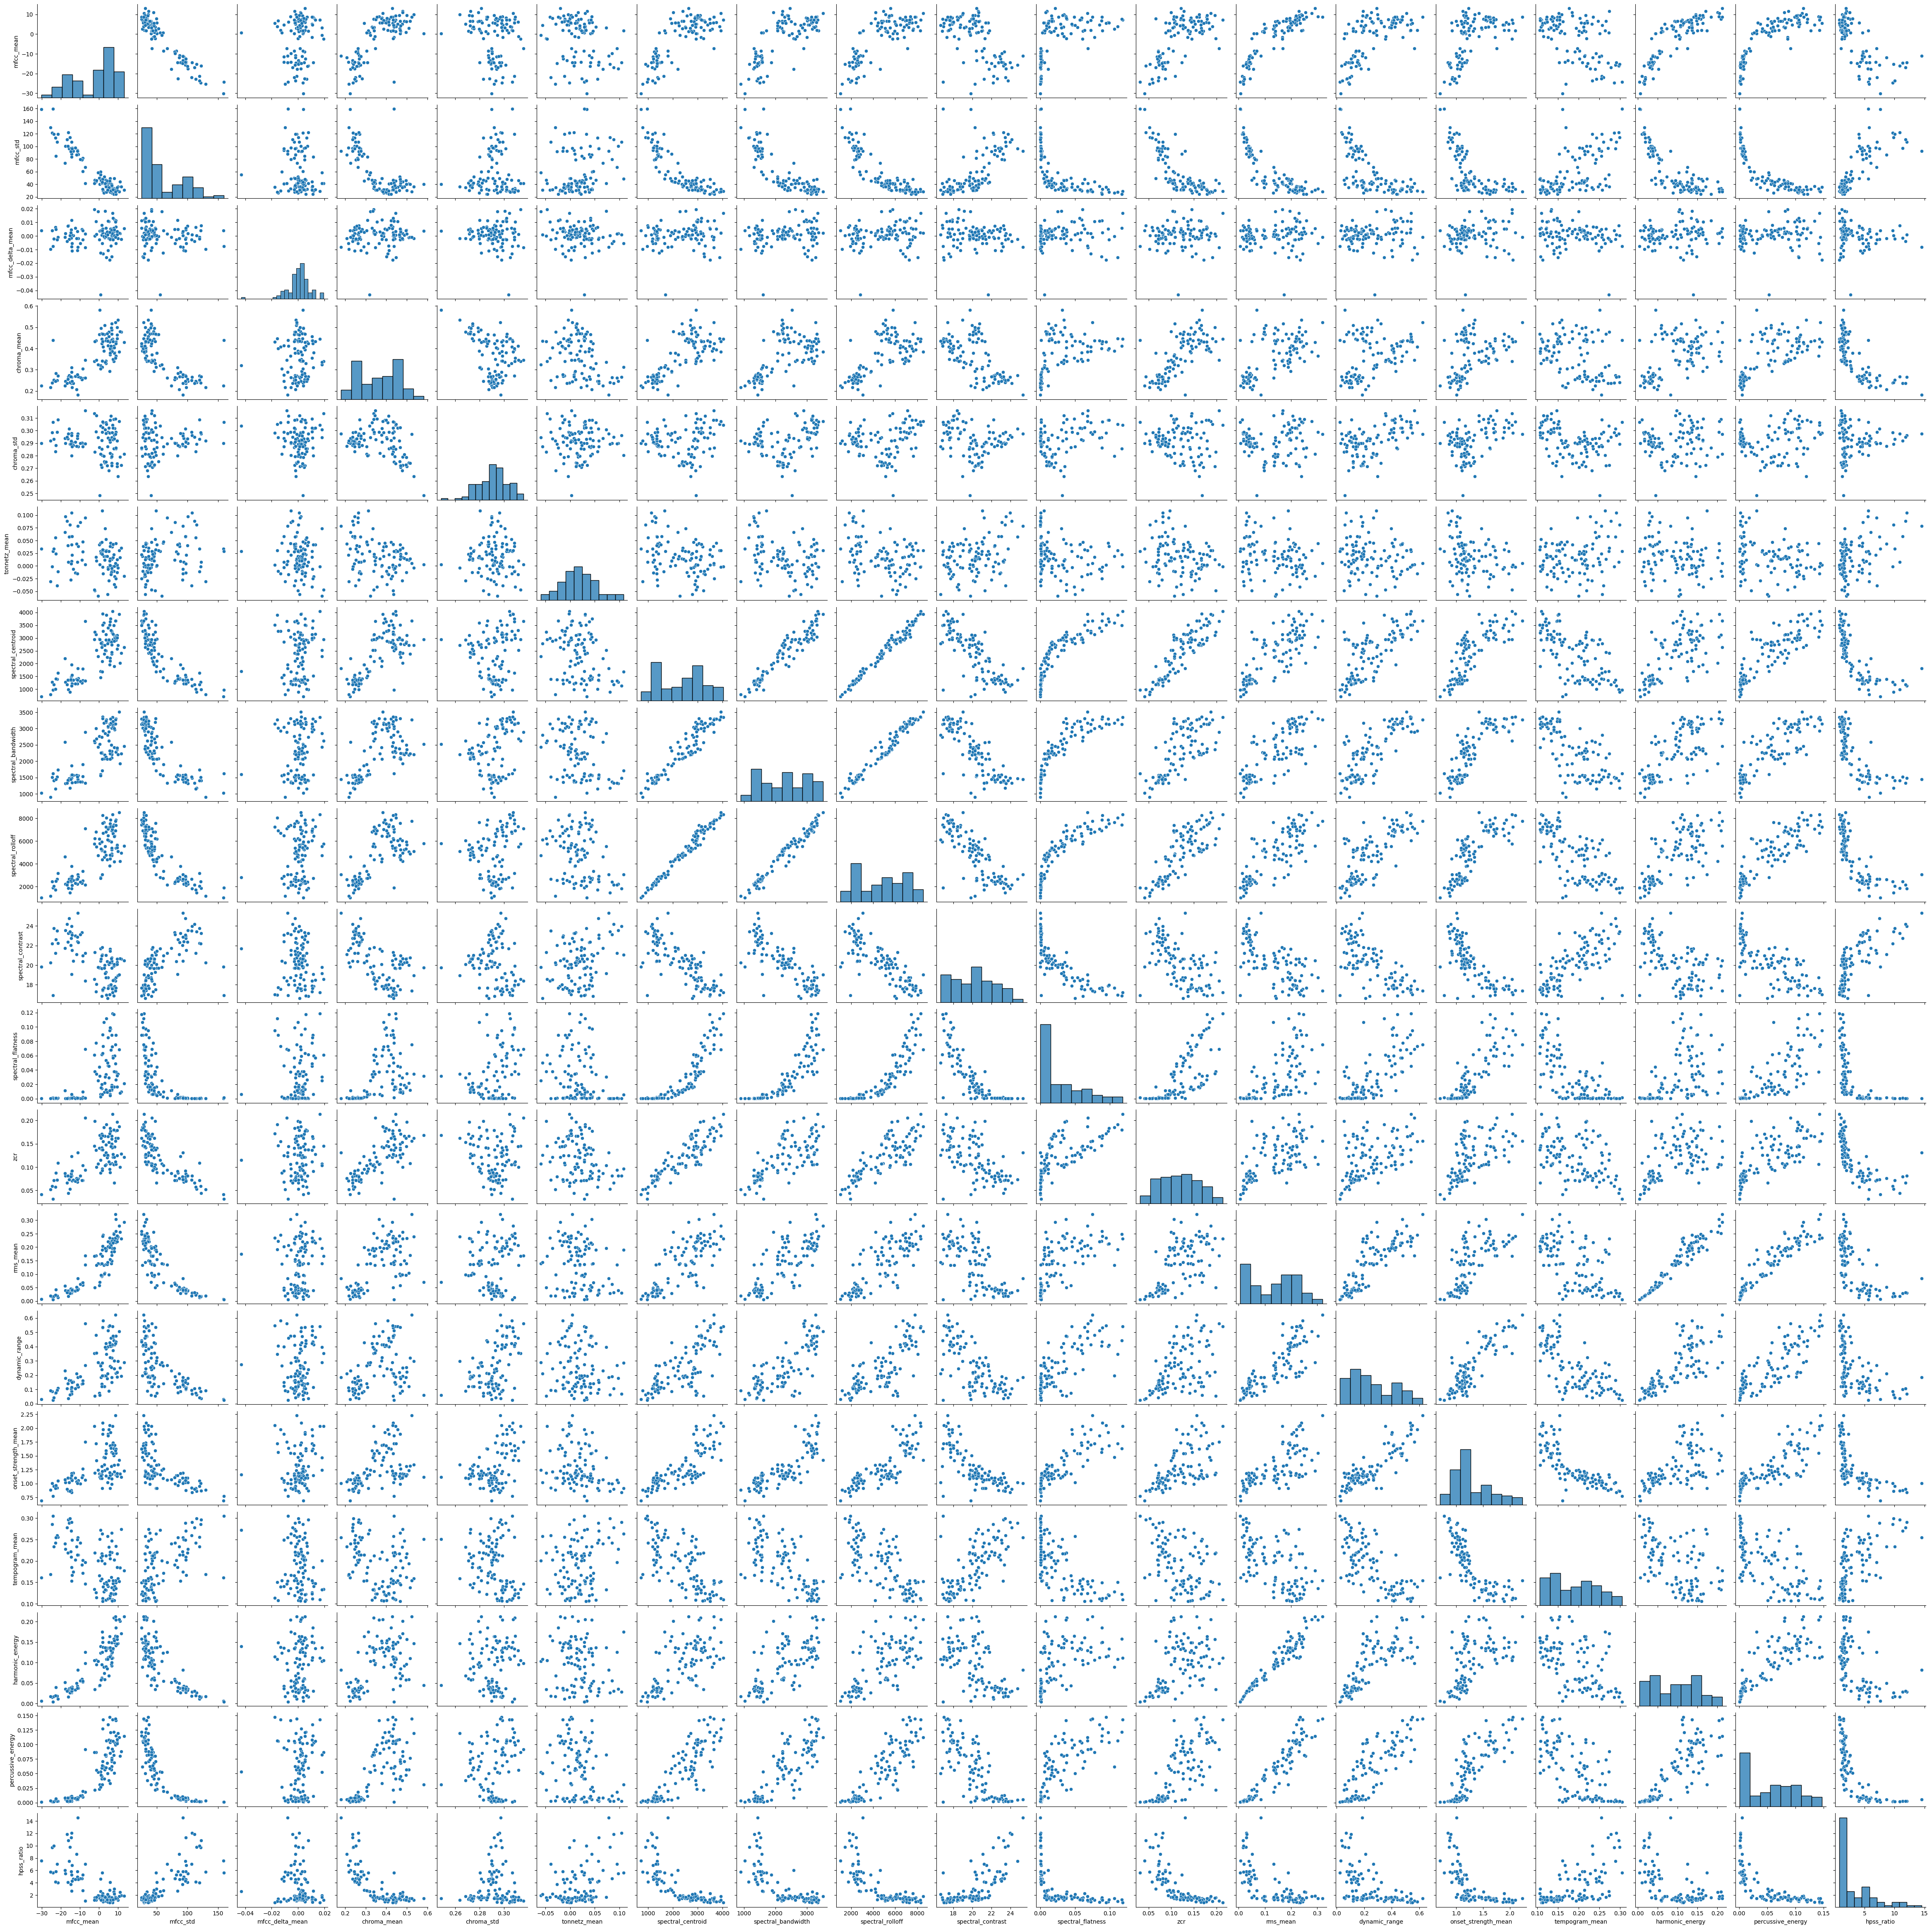

In [14]:
display(df_unlabeled)
sns.pairplot(df_unlabeled[feature_names])

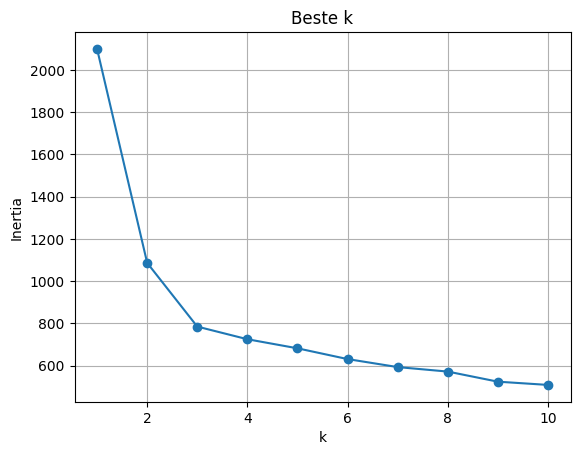

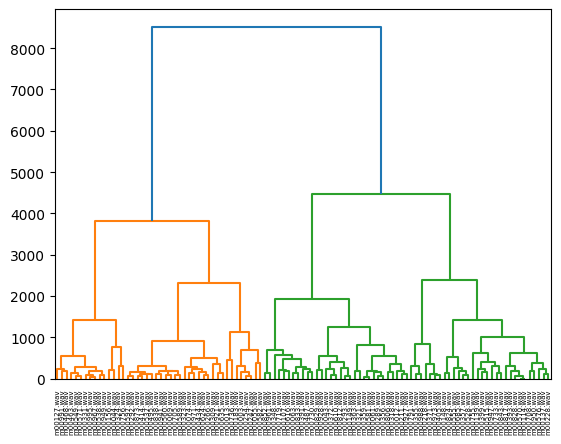

In [15]:
def elbow(df, k_range=range(1, 11), scale=True):


    X = StandardScaler().fit_transform(df) if scale else df.values
    inertias = []

    for k in k_range:
        km = KMeans(n_clusters=k, n_init='auto')
        km.fit(X)
        inertias.append(km.inertia_)

    plt.plot(list(k_range), inertias, marker='o')
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.title("Beste k")
    plt.grid(True)
    plt.show()

    return inertias

elbow(df_unlabeled[feature_names])

merging = linkage(df_unlabeled[feature_names], method='complete')
dendrogram(merging, labels=df_unlabeled['filename'].values)
plt.show()



#### Uitleg
We hebben K-Means uitgevoerd voor een reeks van 1 tot 11 van 𝑘 met behulp van elleboog methode. Uit het dendrogram en met de elleboog methode blijkt een duidelijke sprong in de afstand wanneer het aantal clusters onder vier zakt. Dit betekent dat bij minder dan vier clusters duidelijk verschillende groepen worden samengevoegd. Daarom vormen vier clusters de meest natuurlijke scheiding in de onge­labelde data

### Algoritme onderzoek
#### K-Means

K-Means probeert een dataset op te delen in k clusters door de totale afstand tussen punten en hun centroid te minimaliseren.



$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

waarbij:

- k: aantal clusters  
- Cᵢ: cluster i  
- x: datapunt  
- μᵢ: centroid van cluster i  
- ||x − μᵢ||²: kwadratische Euclidische afstand

##### Werking

Het algoritme begint met het willekeurig kiezen van 𝑘 startcentroids. Vervolgens wordt elk datapunt toegewezen aan het cluster waarvan het centroid zich op de kleinste afstand bevindt. Meestal wordt hiervoor de Euclidische afstand gebruikt. Na deze toewijzing worden de centroids opnieuw berekend door het gemiddelde te nemen van alle datapunten binnen elk cluster. Een cluster is een gebied waar veel punten dicht bij elkaar liggen. Punten die geïsoleerd liggen worden als ruis/noise gemarkeerd. Deze twee stappen, het toewijzen van datapunten en het herberekenen van de centroids, worden herhaald. Het algoritme stopt wanneer de centroids niet meer veranderen of wanneer het maximale aantal iteraties is bereikt. Op dat moment is de clustering geconvergeerd en ligt de uiteindelijke indeling van de data vast.

##### Wanneer werkt K-Means goed:
K-Means werkt vooral goed bij grote datasets waarbij de clusters ongeveer bolvormig zijn en een vergelijkbare grootte en dichtheid hebben. Daarnaast is het belangrijk dat de gebruikte features vooraf zijn geschaald, omdat het algoritme gevoelig is voor verschillen in schaal. Wanneer er weinig outliers aanwezig zijn en de data aan deze voorwaarden voldoet, kan K-Means efficiënt en betrouwbare clusters vormen.
##### Wanneer minder goed:
Het algoritme is minder geschikt voor kleine datasets of datasets met veel outliers, omdat uitschieters een sterke invloed kunnen hebben op de positie van de centroids. Ook presteert K-Means minder goed wanneer clusters verschillende dichtheden hebben of wanneer de data niet-rond gevormde structuren bevat. In dergelijke situaties kunnen andere clusteringmethoden, zoals DBSCAN of hiërarchische clustering, een betere keuze zijn.






### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN groepeert punten op basis van dichtheid in plaats van afstand tot een centroid. Het kan clusters van willekeurige vorm vinden en detecteert automatisch outliers.

#### Belangrijke parameters
- eps — maximale afstand tussen twee punten om als buren te gelden  
- min_samples — minimaal aantal punten om een dense regio te vormen  

#### Werking

Het algoritme verdeelt datapunten eerst in drie categorieën. Core points zijn punten die binnen een straal ε (eps) een minimumaantal buren hebben. Border points hebben zelf te weinig buren om als core point te worden beschouwd, maar liggen wel binnen de ε-afstand van een core point. Noise points zijn punten die niet binnen de buurt van een core point vallen en daardoor niet tot een cluster behoren.

Clusters worden gevormd door te starten bij een core point. Vanuit dit punt worden alle datapunten die binnen de ε-afstand liggen aan hetzelfde cluster toegevoegd. Wanneer een van deze toegevoegde punten zelf ook een core point blijkt te zijn, wordt het cluster verder uitgebreid door opnieuw alle punten binnen diens ε-omgeving toe te voegen. Dit proces herhaalt zich recursief totdat er geen nieuwe core points meer worden gevonden die het cluster kunnen uitbreiden.

Punten die niet bij een cluster horen worden gemarkeerd als noise.

#### Wanneer werkt DBSCAN goed?
DBSCAN werkt goed wanneer de data clusters bevat met een willekeurige of niet-bolvormige structuur. Omdat het algoritme gebaseerd is op dichtheid, is het zeer geschikt voor datasets waarin dichtheid een logische onderliggende structuur vormt. Een belangrijk voordeel van DBSCAN is dat het expliciet omgaat met outliers: punten die niet tot een cluster behoren worden als noise gemarkeerd, waardoor ze de clustering niet verstoren.

#### Wanneer minder goed?
Het algoritme werkt minder goed wanneer de dataset clusters bevat met sterk variërende dichtheden. In zulke gevallen is het moeilijk om één geschikte waarde voor de parameter
ε te kiezen die voor alle clusters goed werkt. Daarnaast presteert DBSCAN minder bij hoge-dimensionale data, omdat afstanden in hogere dimensies minder onderscheidend worden en het bepalen van een zinvolle ε-waarde lastig is. Tot slot is DBSCAN gevoelig voor de schaal van de features; wanneer features niet goed zijn geschaald, kan dit leiden tot onnauwkeurige of misleidende clusteringresultaten.


### Gaussian Mixture Models (GMM)

GMM modelleert data als een mengsel van meerdere Gaussiaanse verdelingen. Het is een flexibel alternatief voor K‑Means en ondersteunt soft clustering. In plaats van harde toewijzing (zoals K‑Means), berekent GMM voor elk punt: De kans dat het bij elk cluster hoort. Het cluster met de hoogste waarschijnlijkheid wordt gekozen.

#### Wiskundig model

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \sigma_k^2)
$$

Een Gaussian Mixture Model (GMM) bestaat uit \(k\) Gaussiaanse componenten en modelleert de kansverdeling van de data als een gewogen som van deze componenten:

Waarbij:
- $\pi_k$ = Menggewicht

- $\mu_k$ = Gemiddelde

- $\sigma_k^2$ = Variantie

#### Werking

Een Gaussian Mixture Model (GMM) is een probabilistisch clusteringalgoritme dat werkt volgens een iteratief optimalisatieproces, meestal het Expectation-Maximization (EM) algoritme. In de eerste stap wordt voor elk datapunt berekend wat de kans is dat dit punt tot elk van de aanwezige clusters behoort. In plaats van een harde toewijzing aan één cluster, krijgt elk datapunt dus een kansverdeling over alle clusters.

Op basis van deze kansverdelingen worden vervolgens de parameters van het model geüpdatet. Dit betreft het opnieuw berekenen van de gemiddelden van de clusters, de covariantiematrices die de vorm en spreiding van de clusters beschrijven, en de menggewichten die aangeven hoe groot het relatieve aandeel van elk cluster is. Deze stappen worden herhaald totdat het model convergeert. Convergentie wordt bereikt wanneer de log-likelihood, een maat voor hoe goed het model de data verklaart, niet langer significant verandert tussen opeenvolgende iteraties.

#### Wanneer werkt GMM goed?
GMM werkt vooral goed wanneer de onderliggende clusters een elliptische of ovaalvormige structuur hebben en wanneer het wenselijk is om gebruik te maken van soft clustering, waarbij datapunten niet strikt aan één cluster worden toegewezen maar een kans krijgen per cluster. Daarnaast is het model goed toepasbaar op data die ongeveer een Gaussiaanse verdeling volgt.

#### Wanneer minder goed?
Het algoritme is minder geschikt in situaties met veel outliers, omdat deze de parameters van de Gaussiaanse componenten sterk kunnen beïnvloeden. Ook presteert GMM minder goed wanneer de clusters sterk niet-Gaussiaans van vorm zijn. Bij hoge-dimensionale data kan het model instabiel worden zonder aanvullende maatregelen zoals regularisatie, omdat het schatten van covariantiematrices dan complex en gevoelig wordt.


### Model kiezen

GMM is in dit geval de beste keuze, omdat het goed werkt met relatief kleine datasets en omdat het gebruikmaakt van soft clustering. Hierdoor krijgt elk datapunt een waarschijnlijkheid per cluster, wat veel informatie oplevert wanneer clusters overlappen of wanneer de dataset beperkt is in omvang. De meeste features van onze dataset zijn ongeveer normaal verdeeld dit is een voordeel voor GMM modellen.

K‑Means is minder geschikt voor onze situatie. Het algoritme presteert vooral goed bij grote datasets en veronderstelt dat clusters rond en duidelijk gescheiden zijn. Bij een kleinere dataset, zoals de onze, leidt dit vaak tot onnauwkeurige of geforceerde clusterindelingen.

DBSCAN is ook geen goede match voor deze data. Het algoritme is gevoelig voor variërende dichtheden en werkt minder goed in hogere dimensies. Onze audio‑features hebben verschillende schalen en dichtheden, waardoor DBSCAN waarschijnlijk ofwel één groot cluster vindt, of juist te veel punten als ‘noise’ markeert.

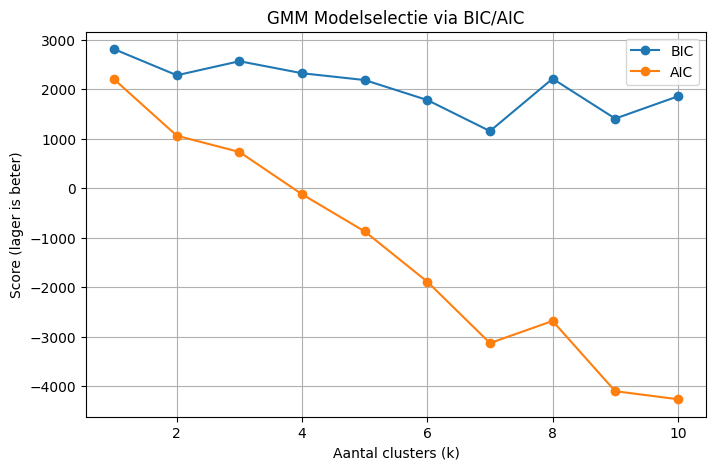

Beste k : 7


filename  mfcc_mean    mfcc_std  mfcc_delta_mean  chroma_mean  \
0    m00156.wav -30.154657  158.767685         0.003996     0.225095   
1    m00289.wav   2.960290   40.840927        -0.001213     0.509197   
2    m00293.wav  11.742577   36.091175        -0.002562     0.478729   
3    m00309.wav -11.054369   92.558594        -0.008054     0.181111   
4    m00107.wav   0.203591   50.187149        -0.002820     0.466651   
..          ...        ...         ...              ...          ...   
100  m00736.wav  -8.569688   60.705158         0.003837     0.305371   
101  m00571.wav -16.863375  111.292824        -0.004007     0.235638   
102  m00321.wav   3.290228   41.307808         0.018264     0.334962   
103  m00495.wav -11.317706   92.499443         0.003222     0.276599   
104  m00247.wav   1.771135   43.431164         0.003823     0.341978   

     chroma_std  tonnetz_mean  spectral_centroid  spectral_bandwidth  \
0      0.289787      0.034065         715.853681         1031.245702   
1      0.274290      0.011799        2710.685064         2194.858595   
2      0.272368      0.035062        2410.877843         2227.683409   
3      0.297486      0.078646        1807.928082         1439.048631   
4      0.286763      0.041652        2966.002258         2759.001396   
..          ...           ...                ...                 ...   
100    0.287258      0.047717        1803.800200         1898.224064   
101    0.294813      0.088630        1180.532490         1332.250313   
102    0.300916      0.073533        2525.591959         2848.409561   
103    0.295816     -0.015109        1358.995445         1516.358151   
104    0.298741      0.022747        2090.193244         2065.324524   

     spectral_rolloff  ...       zcr  rms_mean  dynamic_range  \
0         1038.673121  ...  0.041282  0.006627       0.030173   
1         5083.101617  ...  0.166524  0.104579       0.121136   
2         4950.005438  ...  0.128289  0.231338       0.192799   
3         3073.294358  ...  0.130968  0.084121       0.185882   
4         6189.363682  ...  0.140562  0.058366       0.073017   
..                ...  ...       ...       ...            ...   
100       3366.640534  ...  0.104020  0.068720       0.139814   
101       2154.852451  ...  0.065963  0.031391       0.105630   
102       5552.801896  ...  0.103494  0.195626       0.396451   
103       2668.285283  ...  0.073127  0.040877       0.132666   
104       4392.865033  ...  0.093286  0.166231       0.195669   

                    tempo  onset_strength_mean tempogram_mean  \
0     [67.99958881578948]             0.694108       0.160698   
1         [107.666015625]             1.238460       0.193759   
2    [112.34714673913044]             1.116830       0.273829   
3             [95.703125]             1.008748       0.254746   
4    [117.45383522727273]             1.176674       0.165905   
..                    ...                  ...            ...   
100          [123.046875]             1.267080       0.171882   
101           [95.703125]             0.898861       0.277683   
102   [75.99954044117646]             1.468482       0.133198   
103        [215.33203125]             1.004260       0.213765   
104  [117.45383522727273]             1.224852       0.212728   

     harmonic_energy  percussive_energy  hpss_ratio  GMM_Labels  
0           0.006250           0.000821    7.598611           4  
1           0.059097           0.056631    1.043527           5  
2           0.170958           0.087917    1.944510           6  
3           0.082116           0.005636   14.568403           1  
4           0.043536           0.023537    1.849629           5  
..               ...                ...         ...         ...  
100         0.054829           0.019936    2.750160           4  
101         0.030300           0.002560   11.833170           1  
102         0.136841           0.082045    1.667857           3  
103         0.037373           0.006403    5.836269    

In [16]:
def gmm_select_k(df, k_min=1, k_max=10, covariance_type='full', random_state=42):
    """
    Bepaalt het beste aantal clusters voor GMM met BIC/AIC.
    Geeft terug:
        - beste_k
        - labels
        - BIC-waarden
        - AIC-waarden
    """

    # 1. Schalen
    X = StandardScaler().fit_transform(df)

    bics = []
    aics = []
    models = []

    # 2. Train GMM voor meerdere k's
    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance_type,
            random_state=random_state
        )
        gmm.fit(X)
        bics.append(gmm.bic(X))
        aics.append(gmm.aic(X))
        models.append(gmm)

    # 3. Plot BIC/AIC
    plt.figure(figsize=(8, 5))
    plt.plot(range(k_min, k_max + 1), bics, marker='o', label='BIC')
    plt.plot(range(k_min, k_max + 1), aics, marker='o', label='AIC')
    plt.xlabel("Aantal clusters (k)")
    plt.ylabel("Score (lager is beter)")
    plt.title("GMM Modelselectie via BIC/AIC")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Beste k kiezen (laagste BIC)
    best_k = np.argmin(bics) + k_min
    best_model = models[best_k - k_min]

    # 5. Labels genereren
    labels = best_model.predict(X)

    return best_k, labels, bics, aics

best_k, labels, bics, aics = gmm_select_k(df_unlabeled[feature_names], k_min=1, k_max=10)
print(f"Beste k : {best_k}")
df_unlabeled['GMM_Labels'] = labels
df_unlabeled





### Gaussian Mixture Model (GMM) – Simpele Uitleg

Een **Gaussian Mixture Model (GMM)** gaat ervan uit dat je data afkomstig is uit meerdere normale verdelingen.  
Voor \(K\) componenten is de kansdichtheid:

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \sigma_k^2)
$$

waar:
De parameters van een GMM zijn:


- $\pi_k$ = Menggewicht

- $\mu_k$ = Gemiddelde

- $\sigma_k^2$ = Variantie


De parameters worden geleerd met het **EM‑algoritme**.


#### EM‑algoritme

##### **E‑stap (Expectation)**  
Bereken voor elk datapunt \(x_i\) de kans dat het bij component \(k\) hoort:

$$
\gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \sigma_k^2)}
{\sum_{j=1}^{K} \pi_j \, \mathcal{N}(x_i \mid \mu_j, \sigma_j^2)}
$$

##### **M‑stap (Maximization)**  
Update de parameters:

$$
N_k = \sum_{i=1}^{N} \gamma_{ik}
$$

$$
\mu_k^{\text{nieuw}} = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} x_i
$$

$$
(\sigma_k^2)^{\text{nieuw}} = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} (x_i - \mu_k^{\text{nieuw}})^2
$$

$$
\pi_k^{\text{nieuw}} = \frac{N_k}{N}
$$


##### Klein Rekenvoorbeeld (1D)

We gebruiken een kleine fictieve dataset:

$$
x = [1.0,\; 2.0,\; 5.0]
$$

We nemen **2 Gaussians**.

##### **Initialisatie**

$$
\pi_1 = 0.5,\quad \pi_2 = 0.5
$$

$$
\mu_1 = 1,\quad \mu_2 = 5
$$

$$
\sigma_1^2 = 1,\quad \sigma_2^2 = 1
$$

#### E‑stap (responsibilities)

We gebruiken de normale dichtheid:

$$
\mathcal{N}(x \mid \mu, \sigma^2) =
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

Omdat \(\sigma^2 = 1\), kunnen we vooral naar de exponent kijken.



##### **Voor \(x_1 = 1\)**

Component 1:

$$
\exp\left( -\frac{(1-1)^2}{2} \right) = 1
$$

Component 2:

$$
\exp\left( -\frac{(1-5)^2}{2} \right) = \exp(-8) \approx 0.00034
$$

Responsibilities:

$$
\gamma_{11} \approx 0.9997,\qquad
\gamma_{12} \approx 0.0003
$$



##### **Voor \(x_2 = 2\)**

Component 1:

$$
\exp\left( -\frac{(2-1)^2}{2} \right) = \exp(-0.5) \approx 0.6065
$$

Component 2:

$$
\exp\left( -\frac{(2-5)^2}{2} \right) = \exp(-4.5) \approx 0.0110
$$

Responsibilities:

$$
\gamma_{21} \approx 0.982,\qquad
\gamma_{22} \approx 0.018
$$



#### **Voor \(x_3 = 5\)**

Component 1:

$$
\exp\left( -\frac{(5-1)^2}{2} \right) = \exp(-8)
$$

Component 2:

$$
\exp(0) = 1
$$

Responsibilities:

$$
\gamma_{31} \approx 0.0003,\qquad
\gamma_{32} \approx 0.9997
$$


#### M‑stap (parameters updaten)

##### **Effectieve cluster-groottes**

$$
N_1 = 0.9997 + 0.982 + 0.0003 \approx 1.982
$$

$$
N_2 = 0.0003 + 0.018 + 0.9997 \approx 1.018
$$

##### **Nieuwe menggewichten**

$$
\pi_1^{\text{nieuw}} = \frac{1.982}{3} \approx 0.661
$$

$$
\pi_2^{\text{nieuw}} = \frac{1.018}{3} \approx 0.339
$$

##### **Nieuwe gemiddelden**

Component 1:

$$
\mu_1^{\text{nieuw}} =
\frac{0.9997\cdot1 + 0.982\cdot2 + 0.0003\cdot5}{1.982}
\approx 1.50
$$

Component 2:

$$
\mu_2^{\text{nieuw}} =
\frac{0.0003\cdot1 + 0.018\cdot2 + 0.9997\cdot5}{1.018}
\approx 4.95
$$



#### conclusie

- Component 1 “pakt” de punten rond 1–2 → nieuw gemiddelde ≈ 1.5  
- Component 2 “pakt” het punt rond 5 → nieuw gemiddelde ≈ 4.95  
- Responsibilities geven **zachte** toewijzing (kansen), geen harde clusters.


# bron
https://www.geeksforgeeks.org/machine-learning/gaussian-mixture-model/

In [17]:
df1 = df1.drop(columns=["tempo"])
df_unlabeled = df_unlabeled.drop(columns=["tempo"])

feature_names = [f for f in feature_names if f != "tempo"]

**Waarom is de feature tempo verwijderd?**
Tijdens het extraheren van audiofeatures bleek dat de functie librosa.beat.beat_track() bij sommige geluidsfragmenten geen tempo kon bepalen. In deze gevallen werd de waarde NaN, wat zorgde voor fouten bij het berekenen van gemiddelden, PCA en clustering.
Omdat deze ontbrekende waarden structureel voorkwamen en de resultaten verstoorden, is besloten om de feature tempo volledig te verwijderen uit de analyse. Hierdoor blijft de dataset volledig numeriek en kunnen de modellen betrouwbaar worden toegepast.

In [18]:
# dit heb ik gedaan in de hoop voor duidelijke verschillen per genre
df_genre = df1.drop(columns=['filename']).groupby('genre').mean().reset_index()
df_genre

genre  mfcc_mean   mfcc_std  mfcc_delta_mean  chroma_mean  chroma_std  \
0      blues   0.803459  69.198471         0.000234     0.351571    0.297715   
1  classical -15.278867  94.137100        -0.001504     0.263555    0.289414   
2    country   1.289106  51.597095         0.002996     0.359069    0.287921   
3      disco   2.694232  45.298649        -0.000702     0.409466    0.295285   
4     hiphop   3.432001  45.694393         0.002779     0.516144    0.281864   
5       jazz  -5.286605  73.152298         0.000280     0.276894    0.299505   
6      metal   3.666978  43.212654        -0.000425     0.516712    0.261951   
7        pop   2.807871  38.621033        -0.002634     0.413943    0.294095   
8     reggae  -2.234817  68.142563        -0.000428     0.422877    0.305895   
9       rock  -0.163167  50.372063         0.005092     0.390078    0.283605   

   tonnetz_mean  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0      0.007091        1583.387646         1743.755155       3265.544394   
1      0.029179        1435.502063         1583.313469       2629.373969   
2      0.020666        2083.312910         2181.117729       4306.812158   
3      0.005122        2561.331810         2572.697428       5418.128614   
4      0.000478        2519.631562         2310.307216       5228.446575   
5      0.012262        1675.108026         1944.565406       3532.048176   
6     -0.003056        2557.961237         2188.541721       4955.681011   
7     -0.007740        3102.778575         2952.233656       6523.891069   
8      0.003404        2202.812513         2436.350580       4786.509639   
9      0.001036        2369.401074         2335.257509       4915.969784   

   spectral_contrast  spectral_flatness       zcr  rms_mean  dynamic_range  \
0          21.382800           0.003776  0.076771  0.140737       0.284142   
1          22.110814           0.002710  0.085169  0.048953       0.149793   
2          21.450688           0.022542  0.099472  0.129948       0.206566   
3          19.239101           0.032018  0.113463  0.146992       0.309341   
4          19.999706           0.014526  0.126286  0.109819       0.233122   
5          21.454712           0.003686  0.073069  0.072097       0.188343   
6          19.881724           0.016119  0.152806  0.119193       0.171062   
7          18.045874           0.063260  0.143026  0.184845       0.423100   
8          19.391925           0.025642  0.085836  0.093046       0.234723   
9          20.849270           0.017368  0.118969  0.109434       0.145335   

   onset_strength_mean  tempogram_mean  harmonic_energy  percussive_energy  \
0             1.226573        0.159061         0.104079           0.051101   
1             0.941347        0.261595         0.042520           0.010250   
2             1.339374        0.156542         0.098586           0.046525   
3             1.801914        0.132111         0.086579           0.078311   
4             1.485931        0.189340         0.070254           0.051786   
5             1.293291        0.158983         0.060302           0.019442   
6             1.162095        0.185639         0.072180           0.057868   
7             1.618250        0.152925         0.122876           0.085615   
8             1.900527        0.107541         0.061236           0.043873   
9             1.154572        0.179401         0.080397           0.040821   

   hpss_ratio  
0    3.012999  
1    8.077077  
2    2.241515  
3    1.139015  
4    1.376728  
5    3.873902  
6    1.273866  
7    1.745003  
8    1.583315  
9    2.008281

In [19]:
cluster = df_unlabeled.groupby("GMM_Labels")[feature_names].mean()

cluster

mfcc_mean    mfcc_std  mfcc_delta_mean  chroma_mean  chroma_std  \
GMM_Labels                                                                    
0            5.173263   32.402561         0.009894     0.421936    0.300103   
1          -12.654837   90.155830        -0.002749     0.245990    0.291548   
2            6.559842   43.538349         0.001983     0.399986    0.284745   
3            4.550383   34.737789        -0.001368     0.390106    0.302163   
4          -16.971060  103.395241         0.000794     0.267519    0.292637   
5            2.617534   43.382278         0.000889     0.475977    0.274610   
6            7.268577   36.264236        -0.003666     0.447844    0.283211   

            tonnetz_mean  spectral_centroid  spectral_bandwidth  \
GMM_Labels                                                        
0              -0.006417        3383.563635         3102.975286   
1               0.078799        1423.444522         1528.039297   
2              -0.000727        2249.206328         2257.069620   
3               0.023055        3249.217461         3116.024091   
4               0.012090        1302.990253         1463.764063   
5               0.008877        2746.505962         2346.875205   
6               0.006299        2640.631911         2246.167164   

            spectral_rolloff  spectral_contrast  spectral_flatness       zcr  \
GMM_Labels                                                                     
0                7158.771894          17.666044           0.078916  0.153965   
1                2588.635922          23.018236           0.001896  0.084120   
2                4677.559519          20.420835           0.015590  0.106359   
3                7069.805883          18.144916           0.066138  0.144192   
4                2405.802879          21.769639           0.001550  0.073585   
5                5397.648564          20.280140           0.021422  0.153836   
6                5073.245480          20.004526           0.024004  0.155035   

            rms_mean  dynamic_range  onset_strength_mean  tempogram_mean  \
GMM_Labels                                                                 
0           0.230434       0.481137             1.863550        0.130731   
1           0.062791       0.169101             0.975951        0.256618   
2           0.196619       0.281497             1.202520        0.181678   
3           0.205865       0.427272             1.648311        0.130370   
4           0.033552       0.102518             1.028033        0.218252   
5           0.102025       0.133764             1.182842        0.198047   
6           0.196708       0.207987             1.113753        0.248073   

            harmonic_energy  percussive_energy  hpss_ratio  
GMM_Labels                                                  
0                  0.145646           0.115404    1.280505  
1                  0.058632           0.008535    8.376920  
2                  0.146643           0.071681    2.361789  
3                  0.135133           0.097448    1.447148  
4                  0.029735           0.006341    5.676077  
5                  0.067531           0.045713    1.512121  
6                  0.136799           0.081372    1.759727

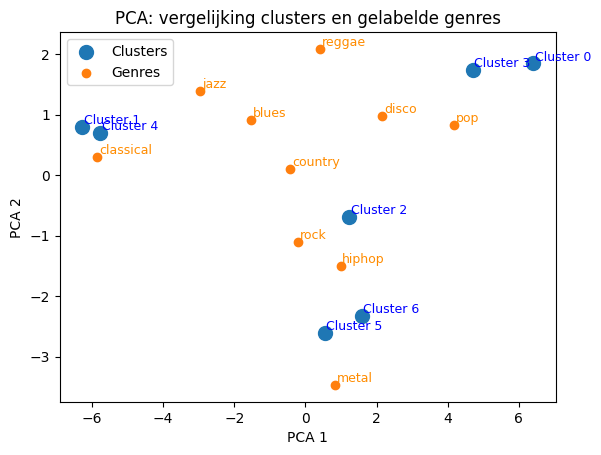

In [20]:
# Gemiddelden gelabeld en ongelabel namen
df_genre = df1.groupby("genre")[feature_names].mean()
cluster_means = df_unlabeled.groupby("GMM_Labels")[feature_names].mean()

# Combineer
combined = pd.concat([cluster_means, df_genre])

# PCA
X_pca = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(combined))


# Clusters
plt.scatter(X_pca[:len(cluster_means), 0],X_pca[:len(cluster_means), 1],marker="o",s=100,label="Clusters")

# Genres
plt.scatter(X_pca[len(cluster_means):, 0],X_pca[len(cluster_means):, 1],marker="o",label="Genres")

# Cluster labels
for i, cluster_id in enumerate(cluster_means.index):
    plt.text(
        X_pca[i, 0] + 0.05,
        X_pca[i, 1] + 0.05,
        f"Cluster {cluster_id}",
        fontsize=9,
        color="blue"
    )

# Genre labels
for i, genre in enumerate(df_genre.index):
    plt.text(
        X_pca[len(cluster_means) + i, 0] + 0.05,
        X_pca[len(cluster_means) + i, 1] + 0.05,
        genre,
        fontsize=9,
        color="darkorange"
    )

plt.legend()
plt.title("PCA: vergelijking clusters en gelabelde genres")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [21]:
import numpy as np

closest = {}

for cluster_id, c_row in cluster_means.iterrows():
    min_dist = float("inf")
    best_genre = None

    for genre, g_row in df_genre.iterrows():
        dist = np.sqrt(((c_row.values - g_row.values) ** 2).sum())
        if dist < min_dist:
            min_dist = dist
            best_genre = genre

    closest[cluster_id] = best_genre



print("Cluster Dichtstbijzijnde genre:")
for c, g in closest.items():
    print(f"Cluster {c} hoort bij {g}")

# Maak nieuwe kolom met voorspelde genres
df_unlabeled_predict = df_unlabeled.copy()
df_unlabeled_predict["Predicted_Genre"] = df_unlabeled_predict["GMM_Labels"].map(closest)
df_unlabeled_predict.head()



Cluster Dichtstbijzijnde genre:
Cluster 0 hoort bij pop
Cluster 1 hoort bij classical
Cluster 2 hoort bij reggae
Cluster 3 hoort bij pop
Cluster 4 hoort bij classical
Cluster 5 hoort bij hiphop
Cluster 6 hoort bij metal


filename  mfcc_mean    mfcc_std  mfcc_delta_mean  chroma_mean  \
0  m00156.wav -30.154657  158.767685         0.003996     0.225095   
1  m00289.wav   2.960290   40.840927        -0.001213     0.509197   
2  m00293.wav  11.742577   36.091175        -0.002562     0.478729   
3  m00309.wav -11.054369   92.558594        -0.008054     0.181111   
4  m00107.wav   0.203591   50.187149        -0.002820     0.466651   

   chroma_std  tonnetz_mean  spectral_centroid  spectral_bandwidth  \
0    0.289787      0.034065         715.853681         1031.245702   
1    0.274290      0.011799        2710.685064         2194.858595   
2    0.272368      0.035062        2410.877843         2227.683409   
3    0.297486      0.078646        1807.928082         1439.048631   
4    0.286763      0.041652        2966.002258         2759.001396   

   spectral_rolloff  ...       zcr  rms_mean  dynamic_range  \
0       1038.673121  ...  0.041282  0.006627       0.030173   
1       5083.101617  ...  0.166524  0.104579       0.121136   
2       4950.005438  ...  0.128289  0.231338       0.192799   
3       3073.294358  ...  0.130968  0.084121       0.185882   
4       6189.363682  ...  0.140562  0.058366       0.073017   

   onset_strength_mean  tempogram_mean  harmonic_energy  percussive_energy  \
0             0.694108        0.160698         0.006250           0.000821   
1             1.238460        0.193759         0.059097           0.056631   
2             1.116830        0.273829         0.170958           0.087917   
3             1.008748        0.254746         0.082116           0.005636   
4             1.176674        0.165905         0.043536           0.023537   

   hpss_ratio  GMM_Labels  Predicted_Genre  
0    7.598611           4        classical  
1    1.043527           5           hiphop  
2    1.944510           6            metal  
3   14.568403           1        classical  
4    1.849629           5           hiphop  

[5 rows x 22 columns]

### PCA

In [22]:

df_unlabeled_pca = df_unlabeled.copy()
df_unlabeled_pca = df_unlabeled_pca.drop(columns=["filename"])
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_unlabeled_pca)

scaled_df_unlabeled = pd.DataFrame(scaled_array,columns=df_unlabeled_pca.columns)

scaled_df_unlabeled.head()


mfcc_mean  mfcc_std  mfcc_delta_mean  chroma_mean  chroma_std  \
0  -2.572644  3.044820         0.408652    -1.478732   -0.137679   
1   0.476766 -0.565915        -0.228342     1.549388   -1.425570   
2   1.285489 -0.711345        -0.393358     1.224647   -1.585257   
3  -0.813782  1.017600        -1.065022    -1.947545    0.502078   
4   0.222914 -0.279748        -0.424888     1.095916   -0.388984   

   tonnetz_mean  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0      0.453561          -1.849998           -1.737198         -1.833371   
1     -0.190552           0.394630           -0.108716          0.136459   
2      0.482401           0.057280           -0.062778          0.071635   
3      1.743226          -0.621172           -1.166476         -0.842413   
4      0.673033           0.681919            0.680804          0.675261   

   spectral_contrast  spectral_flatness       zcr  rms_mean  dynamic_range  \
0          -0.186929          -0.891351 -1.851095 -1.525661      -1.443723   
1          -0.109115          -0.237287  1.132879 -0.376228      -0.861228   
2           0.199105          -0.604896  0.221896  1.111246      -0.402327   
3           2.434876          -0.893088  0.285733 -0.616296      -0.446619   
4          -0.234316           0.440157  0.514302 -0.918525      -1.169366   

   onset_strength_mean  tempogram_mean  harmonic_energy  percussive_energy  \
0            -1.762255       -0.528105        -1.596544          -1.242311   
1            -0.158576        0.071330        -0.654920          -0.000990   
2            -0.516903        1.523082         1.338172           0.694864   
3            -0.835316        1.177086        -0.244786          -1.135237   
4            -0.340600       -0.433703        -0.932183          -0.737077   

   hpss_ratio  GMM_Labels  
0    1.420578    0.569104  
1   -0.796970    1.149259  
2   -0.492173    1.729414  
3    3.778418   -1.171360  
4   -0.524270    1.149259

In [23]:
cov_mat = scaled_df_unlabeled.cov()

In [24]:
eigenvals, eigenvecs = np.linalg.eig(cov_mat)


inds = eigenvals.argsort()
eigenvals = eigenvals[inds[::-1]]
eigenvecs = eigenvecs[inds[::-1]]

print("eigenwaarden",eigenvals)
print("eigenvectoren",eigenvecs)

eigenwaarden [1.21806588e+01 2.41619739e+00 1.28146717e+00 1.09996003e+00
 8.40268617e-01 5.67820483e-01 4.52756699e-01 3.51659670e-01
 2.29158975e-01 2.07117260e-01 1.69717984e-01 1.08417215e-01
 8.62851544e-02 8.05622601e-02 4.84447383e-02 4.29110977e-02
 2.08630562e-02 6.27491242e-03 1.48395832e-03 2.82224606e-04]
eigenvectoren [[-2.48232704e-01 -1.89247351e-01  2.78339509e-01 -7.16896549e-02
  -1.30472423e-01  6.36877081e-03  6.25759340e-02 -9.94843086e-02
  -1.62528906e-01  1.73272160e-01  9.34156303e-02  1.66602728e-01
  -4.44751041e-01 -1.57078903e-01 -2.98804427e-01  7.42276751e-03
   6.11636049e-01 -8.80494172e-02 -4.95911957e-02  5.31548938e-03]
 [ 2.61553235e-01  1.56552151e-01 -1.67247381e-01  3.71501942e-02
   1.47888359e-03 -4.01274845e-02 -4.63202129e-02  2.68117744e-01
   1.33506231e-01 -2.69367365e-01  2.01484953e-01  1.14532368e-01
   4.10539979e-01  8.11258179e-03  1.18008153e-01 -4.98656854e-02
   6.86316126e-01 -2.69919176e-02 -3.33137334e-02 -9.91385826e-03]
 [-4.

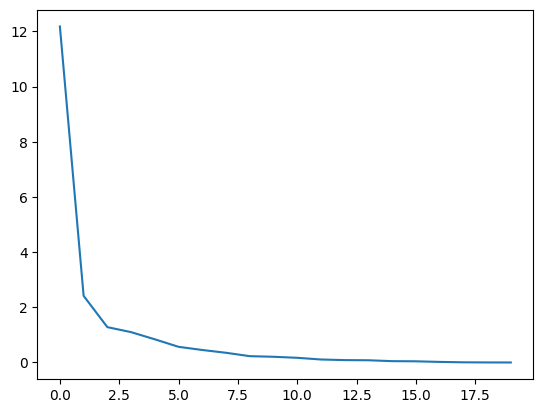

In [25]:
plt.plot(eigenvals)

### Keuze van het aantal componenten (PCA)

In de scree plot zien we dat de eerste component een zeer grote eigenwaarde heeft,
en dat na ongeveer **5 componenten** de lijn sterk afvlakt.

Dit betekent dat de eerste 5 principal components samen het grootste deel van de
variantie in de data verklaren.  
Na dit punt voegen extra componenten nog maar weinig nieuwe informatie toe.

Daarom is gekozen voor:

\[
k = 5
\]

Deze 5 componenten worden gebruikt als nieuwe features voor clustering.


In [26]:
X_scaled = scaled_df_unlabeled
# PCA voor dimensionality reduction (echte modelstap)
pca = PCA(n_components=5)   # gekozen via scree plot
X_pca = pca.fit_transform(X_scaled)

print("Vorm na PCA:", X_pca.shape)



Vorm na PCA: (105, 5)


### Interpretatie

Na PCA bestaat de dataset uit 105 geluidsfragmenten met 5 nieuwe features (principal components) in plaats van de oorspronkelijke audiofeatures.

De dimensie is dus succesvol verlaagd, terwijl de belangrijkste informatie in de data behouden blijft.


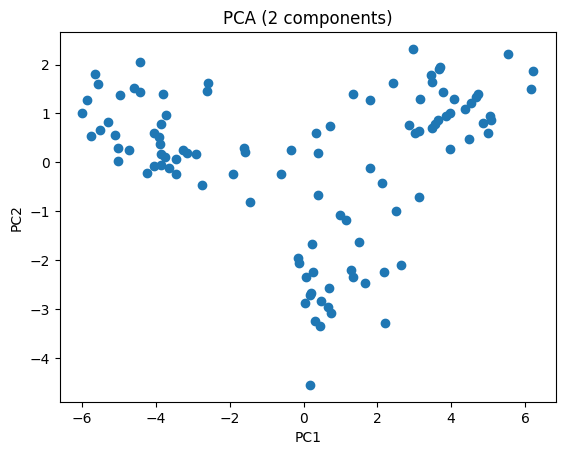

In [27]:
# PCA met 2 componenten voor visualisatie
Z = PCA(n_components=2).fit_transform(X_scaled)
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2 components)")
plt.show()


#### Wiskundige PCA

Principal Component Analysis (PCA), ook wel hoofcomponentenanalyse, is een methode voor dimensionaliteitsreductie: het verminderen van het aantal features (variabelen) in een dataset. PCA wordt vaak toegepast als voorbewerking binnen clusteringmodellen zoals k-means en Gaussian Mixture Models (GMM), om ruis te verminderen en de structuur van de data beter zichtbaar te maken.

In essentie voert PCA een lineaire transformatie uit waarbij de oorspronkelijke data wordt geprojecteerd op een nieuwe ruimte. Deze nieuwe ruimte wordt zo gekozen dat de grootste variantie in de data behouden blijft, maar met zo min mogelijk dimensies.

beginend bij de matrix
$$
X \in \mathbb{R}^{n \times p}
$$
Voordat PCA wordt toegepast, is het belangrijk om de data te standaardiseren. Dit is nodig omdat PCA gevoelig is voor schaalverschillen tussen variabelen. Zonder standaardisatie zouden variabelen met grote eenheden (bijv. euro’s versus percentages) een onevenredig grote invloed hebben op het resultaat. dit kan gedaan worden door
$$
z=\frac{x_i-μ}{σ}
$$
Op basis van de gestandaardiseerde matrix kan nu de covariantiematrix worden bepaald. De covariantie meet in welke mate twee variabelen samen variëren.
De covariantie tussen twee variabelen

$$
cov x,y = \frac{Σ(x_i-x̄)(y_i-ȳ)}{N-1}
$$


Na het bepalen van de covariantiematrix vormt de volgende stap in PCA het berekenen van de eigenwaarden en eigenvectoren van deze matrix. Deze vormen de kern van de Principal Component Analysis.

Eigendecompositie van de covariantiematrix Laat Σ de covariantiematrix zijn van de gestandaardiseerde data 𝑋 std

$$
Σ\in \mathbb{R}^{p \times p}
$$
De eigendecompositie van deze matrix wordt gegeven door:
$$
Σv=λv
$$

Elke eigenvector geeft een richting aan in de oorspronkelijke feature-ruimte. Deze richting correspondeert met een nieuwe as in de getransformeerde ruimte en wordt een principal component genoemd.

De bijbehorende eigenwaarde geeft aan hoeveel variantie er in de data wordt verklaard door de bijbehorende principal component.


De eigenwaarden en eigenvectoren worden gesorteerd in aflopende volgorde van eigenwaarde. De bijbehorende eigenvectoren vormen de nieuwe basis van de getransformeerde ruimte.
Door alleen de eerste k componenten te kiezen (waarbij 𝑘<p), wordt de dimensionaliteit gereduceerd terwijl het grootste deel van de variantie behouden blijft.



een voorbeeld van het gebruik zou kunnen zijn

X(je matrix)  
$$
X =
\begin{pmatrix}
1  &     2 \\
2 & 4
\\
3 & 6
\end{pmatrix}
$$

na standardisatie zou X
$$
X =
\begin{pmatrix}
-1  &     -2 \\
0 & 0
\\
1 & 2
\end{pmatrix}
$$

Nu kan de conversie matrix bepaald worden
door middel van
$$
cov x,y = \frac{Σ(x_i-x̄)(y_i-ȳ)}{N-1}
$$
maar deze formule is niet optimaal voor het gemak maak ik gebruik van
$$
\Sigma = \frac{1}{n-1}\, X_{\text{}}^\top X_{\text{}}
$$
hierbij wordt X^⊤ (de getransponeerde versie van de orginele conversie matrix) vermedigvuldigd met de conversie matrix
hier uit volgt


$$
\begin{pmatrix}
-1  &     -2 \\
0 & 0
\\
1 & 2
\end{pmatrix}
*
\begin{pmatrix}
-1  &     -0 & 1\\
-2 & 0& 2
\end{pmatrix}
$$

hieruit volgt
$$
 X_{\text{}}^\top X_{\text{}} =
 \begin{pmatrix}
2  &   4\\
4 & 8
\end{pmatrix}

$$
nu moet nog het gene hieronder toegepast worden
$$

 \frac{1}{n-1}\ *\begin{pmatrix}
2  &   4\\
4 & 8
\end{pmatrix}

=

 \begin{pmatrix}
1  &   2\\
2 & 4
\end{pmatrix}
$$
dit is nieuwe matrix

vanuit hier kunnen de eigenwaarden en eigen vectoren bepaald worden


## PCA + GMM opnieuw uitvoeren en vergelijken

### Theorie

Na dimensionality reduction vervangen de PCA-componenten de originele features.  
De transformatie kan wiskundig worden geschreven als:

$$
Z = X W_k
$$

waarbij:

- $X$ = geschaalde oorspronkelijke data  
- $W_k$ = matrix met de eerste $k$ eigenvectoren  
- $Z$ = nieuwe PCA-features (principal components)

Hierop passen we opnieuw **Gaussian Mixture Model (GMM)** toe.

GMM modelleert de kansverdeling van de data als een som van Gaussische verdelingen:

$$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

waarbij:

- $K$ = aantal clusters  
- $\pi_k$ = menggewicht van cluster $k$  
- $\mu_k$ = gemiddelde vector van cluster $k$  
- $\Sigma_k$ = covariantiematrix van cluster $k$

Door GMM opnieuw toe te passen op de PCA-features kunnen we onderzoeken of de  
clusters duidelijker worden en of de scheiding tussen groepen verbetert.



# Non-negative Matrix Factorization (NMF)

Non-negative Matrix Factorization (NMF) is een techniek voor dimensionality reduction
waarbij een dataset wordt samengevat in een kleiner aantal nieuwe kenmerken.
In plaats van te werken met alle oorspronkelijke audiofeatures, beschrijven we
elk geluidsfragment met een paar “onderliggende patronen”.

Bij NMF proberen we de originele datamatrix te benaderen met twee nieuwe matrices:

$$
X \approx W \cdot H
$$

Hierbij is **X** de oorspronkelijke dataset, **W** de nieuwe representatie van elk
geluidsfragment en **H** een matrix die laat zien hoe de nieuwe componenten zijn
opgebouwd uit de originele features.

Omdat alle waarden in deze matrices niet-negatief zijn, kan elk fragment worden
gezien als een optelsom van onderdelen. Dit maakt NMF goed te interpreteren:
elk nummer bestaat uit een combinatie van basispatronen.

Wiskundig probeert NMF het verschil tussen de originele matrix en de reconstructie
zo klein mogelijk te maken door de volgende fout te minimaliseren:

$$
\min_{W,H} \; \|X - W H\|_F^2
$$

Dit betekent dat NMF zoekt naar W en H die samen X zo goed mogelijk benaderen.

Om dit idee te verduidelijken, bekijken we een klein voorbeeld:

$$
X =
\begin{bmatrix}
4 & 2 \\
3 & 1 \\
2 & 2
\end{bmatrix}
$$

Deze matrix kan worden benaderd door:

$$
W =
\begin{bmatrix}
1 & 2 \\
1 & 1 \\
1 & 0
\end{bmatrix},
\quad
H =
\begin{bmatrix}
2 & 1 \\
1 & 1
\end{bmatrix}
$$

Als we deze matrices met elkaar vermenigvuldigen, krijgen we:

$$
W \cdot H =
\begin{bmatrix}
4 & 3 \\
3 & 2 \\
2 & 1
\end{bmatrix}
\approx X
$$

Dit laat zien dat de oorspronkelijke data kan worden opgebouwd uit twee
onderliggende componenten.

In dit project is gekozen voor:

$$
k = 6
$$

Dit betekent dat elk geluidsfragment nu wordt beschreven met zes nieuwe
NMF-features in plaats van alle oorspronkelijke audiokenmerken.

De vorm van de data wordt hierdoor:

$$
(105, 6)
$$

Deze nieuwe representatie wordt daarna gebruikt om opnieuw clustering toe te
passen en te onderzoeken of de structuur in de data duidelijker zichtbaar wordt.



In [28]:
# We gebruiken hier de originele (ongescaleerde) audiofeatures.
# Deze versie bevat nog geen negatieve waarden door standaardisatie.
X_orig = df_unlabeled[feature_names].copy()

In [29]:
# NMF kan niet werken met negatieve waarden.
# Daarom verwijderen we alle kolommen die ergens een negatieve waarde bevatten.
neg_cols = X_orig.columns[(X_orig < 0).any(axis=0)]
print("Kolommen met negatieve waarden:", list(neg_cols))

X_nmf = X_orig.drop(columns=neg_cols)

print("Vorm na verwijderen negatieve kolommen:", X_nmf.shape)
print("Nog negatieve waarden?", (X_nmf < 0).any().any())


Kolommen met negatieve waarden: ['mfcc_mean', 'mfcc_delta_mean', 'tonnetz_mean']
Vorm na verwijderen negatieve kolommen: (105, 16)
Nog negatieve waarden? False


### Verwijderen van negatieve waarden voor NMF

NMF kan alleen werken met niet-negatieve waarden In onze dataset zaten nog enkele kolommen met negatieve waarden, zoals `mfcc_mean`, `mfcc_delta_mean` en `tonnetz_mean`.

Daarom hebben we deze volledige kolommen verwijderd Dit is nodig omdat NMF anders geen oplossing kan vinden.

Na het verwijderen blijven er 16 geldige audiokenmerken over.  
De nieuwe vorm van de dataset is:

**(105, 16)**


Dit betekent: 105 geluidsfragmenten met 16 niet-negatieve features.


In [30]:
# We passen NMF toe om de data te reduceren naar 6 nieuwe componenten.
# Elke rij krijgt nu een nieuwe representatie met 6 NMF-features.
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=6, random_state=42)

W = nmf_model.fit_transform(X_nmf)
H = nmf_model.components_

print("Vorm W:", W.shape)
print("Vorm H:", H.shape)



Vorm W: (105, 6)
Vorm H: (6, 16)


### Betekenis van matrices W en H

Bij NMF wordt de originele matrix \( X \) benaderd door twee nieuwe matrices:

$$
X \approx W \cdot H
$$

De vormen die we krijgen zijn:

$$
W \in \mathbb{R}^{105 \times 6}, \quad H \in \mathbb{R}^{6 \times 16}
$$

Dit betekent:
- **W** bevat per geluidsfragment de sterkte van elk van de 6 NMF-componenten.
- **H** laat zien hoe elke component is opgebouwd uit de 16 originele features.

Samen reconstrueren ze de oorspronkelijke data zo goed mogelijk.


In [31]:
# We zetten de NMF-uitkomst om in een dataframe.
# Deze nieuwe features gebruiken we straks voor clustering.
nmf_features = pd.DataFrame(W, columns=[f"NMF_{i+1}" for i in range(6)])
display(nmf_features)


NMF_1     NMF_2     NMF_3     NMF_4     NMF_5     NMF_6
0    2.195145  0.000000  0.000000  0.000000  0.000000  0.221039
1    7.369637  0.000000  0.000000  0.000000  0.002639  0.956673
2    6.932480  0.008926  0.000000  0.000000  0.000000  0.928366
3    4.667004  0.000000  0.000000  0.000000  0.000651  0.592094
4    8.545735  0.016751  0.000000  0.000000  0.000000  1.156444
..        ...       ...       ...       ...       ...       ...
100  5.486763  0.000000  0.000000  0.000000  0.000000  0.639835
101  0.978438  0.000000  0.000000  0.000000  0.163123  0.371873
102  8.047453  0.000000  0.001797  0.000287  0.000000  1.046404
103  4.077621  0.000000  0.000000  0.000000  0.000000  0.517403
104  6.161330  0.005141  0.000000  0.000000  0.000000  0.828932

[105 rows x 6 columns]

### Nieuwe NMF-representatie

Elke rij in deze tabel stelt één geluidsfragment voor, maar nu beschreven met 6 nieuwe NMF-features in plaats van de originele audiokenmerken.

Deze waarden geven aan hoe sterk elk fragment bestaat uit de onderliggende patronen die NMF heeft gevonden.

Deze nieuwe representatie gebruiken we hierna voor clustering.


In [32]:
# We passen hetzelfde clustering-algoritme opnieuw toe op de NMF-features.
# Zo kunnen we vergelijken of de clustering verbetert.
from sklearn.mixture import GaussianMixture

gmm_nmf = GaussianMixture(n_components=6, random_state=42)
nmf_labels = gmm_nmf.fit_predict(nmf_features)

df_unlabeled["GMM_NMF_Labels"] = nmf_labels


In [33]:
# We vergelijken de kwaliteit van de originele clustering met die op NMF-features.
# Verdeling van originele clustering
print("Originele clustering:")
print(df_unlabeled["GMM_Labels"].value_counts().sort_index())

# Verdeling van NMF-clustering
print("\nNMF clustering:")
print(df_unlabeled["GMM_NMF_Labels"].value_counts().sort_index())




Originele clustering:
GMM_Labels
0    11
1    13
2    13
3    23
4    24
5    13
6     8
Name: count, dtype: int64

NMF clustering:
GMM_NMF_Labels
0    27
1    29
2     9
3     1
4    24
5    15
Name: count, dtype: int64


### Vergelijking van clusterverdelingen

Hierboven zien we het aantal fragmenten per cluster vóór en na NMF.

De verdeling na NMF is duidelijk anders. Sommige clusters zijn groter geworden en andere juist kleiner.  
Dit laat zien dat NMF de data anders structureert dan de oorspronkelijke PCA-representatie.

Het suggereert dat de onderliggende patronen in de data beter zichtbaar worden na NMF.


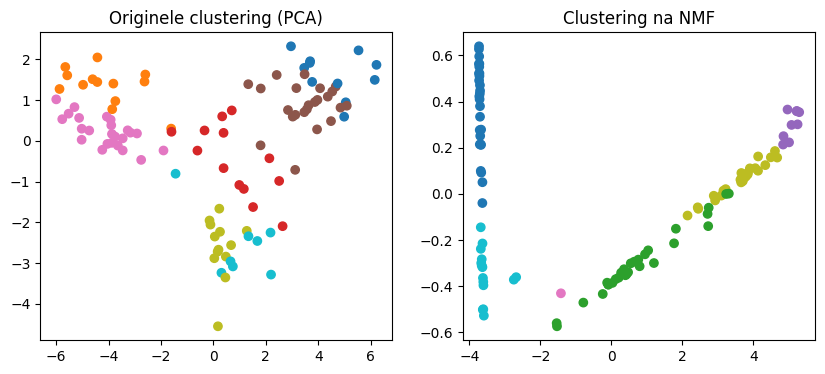

In [34]:
Z_nmf = PCA(n_components=2).fit_transform(nmf_features)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(Z[:,0], Z[:,1], c=df_unlabeled["GMM_Labels"], cmap="tab10")
plt.title("Originele clustering (PCA)")

plt.subplot(1,2,2)
plt.scatter(Z_nmf[:,0], Z_nmf[:,1], c=df_unlabeled["GMM_NMF_Labels"], cmap="tab10")
plt.title("Clustering na NMF")

plt.show()


### Vergelijking van clustering vóór en na NMF

Links zien we de originele clustering op PCA-features.  
Rechts zien we de clustering na toepassing van NMF.

In de NMF-plot liggen de punten meer langs duidelijke structuren.  
Dit wijst erop dat NMF de data heeft samengevat op een manier die de onderliggende patronen beter zichtbaar maakt.

Daarom lijkt clustering na NMF beter de interne structuur van de dataset te volgen.


# Aanbevelingsapp voor geluidsfragmenten

In [ ]:
#!pip install ipywidgets  # haal de eerste hastag weg om ipywidgets te installeren

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00


In [62]:
import ipywidgets as widgets
from IPython.display import display
import IPython.display as ipd
import librosa

dropdown = widgets.Dropdown(
    options=list(df_unlabeled["filename"]),
    description="Kies fragment:",
    layout={'width': '300px'}
)

display(dropdown)

output = widgets.Output()
display(output)

def play_audio(audiofile):
    audio, sr = librosa.load('unlabeled/'+audiofile, sr=None)
    return ipd.Audio(audio, rate=sr)

def recommend_songs(selected_file):
    row = df_unlabeled[df_unlabeled["filename"] == selected_file].iloc[0]
    cluster = row["GMM_NMF_Labels"]

    similar = df_unlabeled[
        (df_unlabeled["GMM_NMF_Labels"] == cluster) &
        (df_unlabeled["filename"] != selected_file)
    ]["filename"].head(5)

    with output:
        output.clear_output()

        print("Gekozen fragment:")
        display(play_audio(selected_file))

        print("\nAanbevolen fragmenten:")
        for f in similar:
            print("-", f)


def on_change(change):
    recommend_songs(change["new"])

dropdown.observe(on_change, names="value")



Dropdown(description='Kies fragment:', layout=Layout(width='300px'), options=('m00156.wav', 'm00289.wav', 'm00…

Output()

## Bevindingen en conclusie

In dit project is onderzocht hoe geluidsfragmenten geclusterd kunnen worden op basis van audiofeatures, en in hoeverre dimensionality reduction hierbij kan helpen. Eerst is gewerkt met de oorspronkelijke audiokenmerken, zoals MFCC’s, chroma, spectrale eigenschappen en energie. Daarna zijn deze kenmerken samengevat met PCA en NMF, en is het clusteringproces opnieuw uitgevoerd.

Uit de resultaten blijkt dat vooral kenmerken die iets zeggen over de klankkleur en energie van een nummer belangrijk zijn voor het groeperen van fragmenten. Dit is te zien in de NMF-matrix **H**, waarin onder andere spectrale eigenschappen en energie-gerelateerde features sterk bijdragen aan de componenten. Deze features lijken dus een grote rol te spelen in het onderscheid tussen de clusters. Ritme- en toonhoogte-achtige kenmerken spelen ook een rol, maar minder dominant dan de spectrale en energetische eigenschappen.

Dimensionality reduction had een duidelijk effect op de structuur van de data. Bij PCA werd zichtbaar dat een klein aantal componenten al het grootste deel van de informatie bevat. Door het aantal dimensies te verlagen werd de ruis verminderd en werd de globale structuur van de data beter zichtbaar in de visualisaties. Bij NMF werd de data niet alleen compacter, maar ook interpreteerbaarder, omdat elk fragment nu werd beschreven als een combinatie van onderliggende patronen. In de PCA-visualisaties na NMF waren de clusters compacter en minder willekeurig verspreid dan bij de originele features. Dit laat zien dat dimensionality reduction niet alleen helpt om het model eenvoudiger te maken, maar ook om de interne structuur van de data beter naar voren te brengen.

De aanbevelingsapp die op basis van de clustering is gemaakt, laat zien dat fragmenten uit hetzelfde cluster vaak ook qua klank bij elkaar passen. Toch is duidelijk dat audiofeatures alleen niet genoeg zijn om echt persoonlijke aanbevelingen te doen. Voor betere suggesties zouden extra gegevens nodig zijn, zoals luistergeschiedenis, voorkeuren van gebruikers, tempo- of stemmingslabels, en eventueel metadata zoals artiest, genre of populariteit. Door deze informatie te combineren met de audioprofielen kan een aanbevelingssysteem veel gerichter en persoonlijker worden.

Samenvattend laat dit project zien dat dimensionality reduction een belangrijke rol speelt bij het analyseren en structureren van complexe audiogegevens. Zowel PCA als NMF helpen om patronen zichtbaar te maken die met de oorspronkelijke features moeilijk te zien zijn. Hierdoor wordt clustering stabieler en ontstaat een betere basis voor eenvoudige aanbevelingssystemen.
